# collect-bananas

---

### 1. Import the Necessary Packages

In [1]:
from unityagents import UnityEnvironment
import numpy as np
from dqn_agent import Agent

import torch
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline

### 2. Instantiate the Environment and Agent

Initialize the environment in the code cell below.

The environment used in this example is for Windows 64-bit. If you want to use the environment for Linux, Mac OS or Windows 32-bit, please download the wanted environment from [here](https://github.com/udacity/deep-reinforcement-learning/tree/master/p1_navigation#getting-started), insert it into the project and change the pathin this line ```env = UnityEnvironment(file_name="Banana_Windows_x86_64/Banana.exe")``` to match the path to the new environment.

In [2]:
env = UnityEnvironment(file_name="Banana_Windows_x86_64/Banana.exe")

# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents in the environment
print('Number of agents:', len(env_info.agents))

# number of actions
action_size = brain.vector_action_space_size
print('Number of actions:', action_size)

# examine the state space 
state = env_info.vector_observations[0]
print('States look like:', state)
state_size = len(state)
print('States have length:', state_size)

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Number of agents: 1
Number of actions: 4
States look like: [1.         0.         0.         0.         0.84408134 0.
 0.         1.         0.         0.0748472  0.         1.
 0.         0.         0.25755    1.         0.         0.
 0.         0.74177343 0.         1.         0.         0.
 0.25854847 0.         0.         1.         0.         0.09355672
 0.         1.         0.         0.         0.31969345 0.
 0.        ]
States have length: 37


### 3. Take Random Actions in the Environment

In the next code cell, an untrained agent will be instantiated and put into the environment for one episode. Since the agent is untrained, its steps will be random. 

In [3]:
env_info = env.reset(train_mode=False)[brain_name] # reset the environment
agent = Agent(state_size=state_size, action_size=action_size, seed=0)

state = env_info.vector_observations[0]            # get the current state
score = 0                                          # initialize the score
for i in range(300):
    action = np.random.randint(action_size)        # select an action
    env_info = env.step(action)[brain_name]        # send the action to the environment
    next_state = env_info.vector_observations[0]   # get the next state
    reward = env_info.rewards[0]                   # get the reward
    done = env_info.local_done[0]                  # see if episode has finished
    score += reward                                # update the score
    state = next_state                             # roll over the state to next time step
    if done:                                       # exit loop if episode finished
        break
    
print("Score: {}".format(score))

Score: 0.0


### 4. Train the Agent

In the next two code cells, a Deep Q-Learning algorithm is used to train the agent.

The training stops when the agent reaches an average score of 15 over the last 100 episodes. When the goal is reached, the model weights are saved into ```model_weights.pth```.

In [4]:
def dqn_train(n_episodes=1000, max_t=300, eps_start=1.0, eps_end=0.01, eps_decay=0.995):
    """Deep Q-Learning - training.
    
    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
    """
    scores = []                        # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores
    eps = eps_start                    # initialize epsilon
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name] # reset the environment
        state = env_info.vector_observations[0]            # get the current state
        score = 0
        for t in range(max_t):
            action = agent.act(state, eps)
            env_info = env.step(action.astype(int))[brain_name]        # send the action to the environment
            next_state = env_info.vector_observations[0]               # get the next state
            reward = env_info.rewards[0]                               # get the reward
            done = env_info.local_done[0]                              # see if episode has finished
            score += reward
            agent.step(state, action, reward, next_state, done)
            state = next_state
            if done:
                break 
        scores_window.append(score)       # save most recent score
        scores.append(score)              # save most recent score
        eps = max(eps_end, eps_decay*eps) # decrease epsilon
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
        if np.mean(scores_window)>=15.0:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
            torch.save(agent.qnetwork_local.state_dict(), 'model_weights.pth')
            break
    return scores

Episode 100	Average Score: 0.35
Episode 200	Average Score: 2.28
Episode 300	Average Score: 6.19
Episode 400	Average Score: 9.81
Episode 500	Average Score: 12.56
Episode 600	Average Score: 14.27
Episode 700	Average Score: 14.12
Episode 800	Average Score: 14.63
Episode 815	Average Score: 15.02
Environment solved in 815 episodes!	Average Score: 15.02


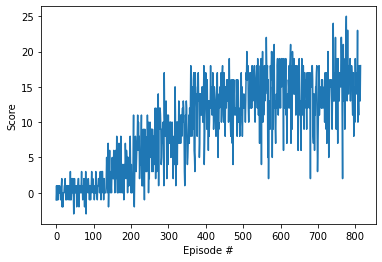

In [5]:
agent = Agent(state_size=state_size, action_size=action_size, seed=0)
scores = dqn_train()

# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

### 5. Test the Agent

In the next two code cells, our trained agent is put into the environment for 100 episodes to measure the result.

In [6]:
def dqn_test(n_episodes=100, max_t=300):
    """Deep Q-Learning - testing.
    
    Params
    ======
        n_episodes (int): number of testing episodes
        max_t (int): maximum number of timesteps per episode
    """
    scores = []                        # list containing scores from each episode
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=False)[brain_name] # reset the environment
        state = env_info.vector_observations[0]            # get the current state
        score = 0
        for t in range(max_t):
            action = agent.act(state)
            env_info = env.step(action.astype(int))[brain_name]        # send the action to the environment
            next_state = env_info.vector_observations[0]               # get the next state
            reward = env_info.rewards[0]                               # get the reward
            done = env_info.local_done[0]                              # see if episode has finished
            state = next_state
            score += reward
            if done:
                break 
        scores.append(score)              # save most recent score
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores)), end="")
    return scores

Episode 100	Average Score: 15.15

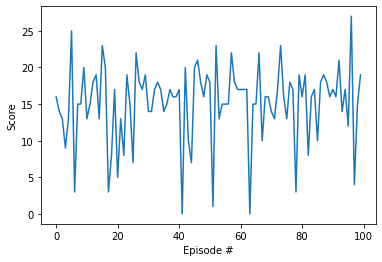

In [7]:
agent.qnetwork_local.load_state_dict(torch.load('model_weights.pth'))
scores = dqn_test()

# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

### 6. Close the environment

In [8]:
env.close()